In [44]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import re
from datetime import datetime
import os

from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix
import seaborn as sns

import datetime as dt

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import keras

import math
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


## Fashion MNIST

In [45]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

In [142]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


TypeError: only integer scalar arrays can be converted to a scalar index

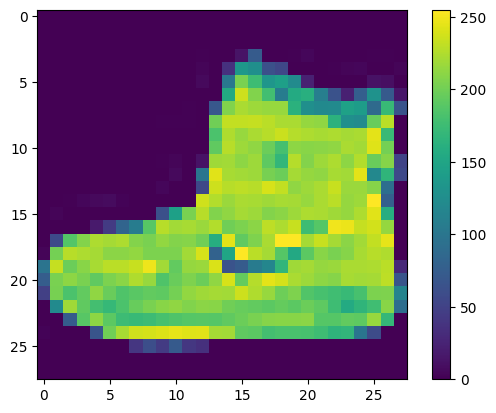

In [47]:
plt.figure()
plt.imshow(fashion_train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [48]:
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot
Trouser
T-shirt/top
Shirt
Coat
Dress
Trouser
Coat
Bag
Coat


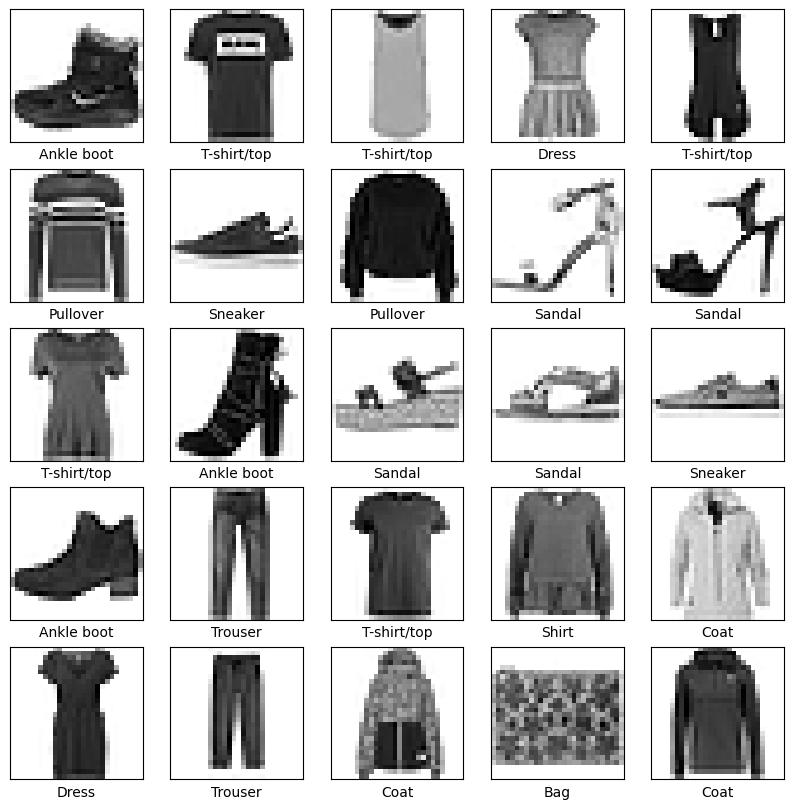

In [141]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[fashion_train_labels[i]])
plt.show()

In [50]:
batch_size = 32
num_classes = 20
epochs = 2

row_hidden = 64
col_hidden = 64

In [51]:
# Input layer
input_layer = tf.keras.Input(shape=(28, 28))

# Permute the dimensions for column-wise processing
permuted_input = tf.keras.layers.Permute((2, 1))(input_layer)

# First branch with two 1D convolutional layers followed by a bidirectional LSTM
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x1)
x1 = tf.keras.layers.LSTM(64, name='LSTM_left', use_bias=False)(x1)

# Second branch with permuted input, two 1D convolutional layers, and a bidirectional LSTM
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(permuted_input)
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x2)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x2)
x2 = tf.keras.layers.LSTM(64, name='LSTM_right', use_bias=False)(x2)

# Concatenate the outputs of the two branches
concatenated = tf.keras.layers.Concatenate()([x1, x2])

# Apply dropout
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# Output layer
output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout)

# Create the model
model_fashion_lstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_fashion_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_fashion_lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 permute_1 (Permute)         (None, 28, 28)               0         ['input_2[0][0]']             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 28, 64)               5440      ['input_2[0][0]']             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 28, 64)               5440      ['permute_1[0][0]']           
                                                                                            

In [21]:
model_fashion_lstm.fit(fashion_train_images, fashion_train_labels, epochs=4, batch_size=batch_size)

Epoch 1/4
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2453 - accuracy: 0.9094
Epoch 2/4
1875/1875 [==============================] - 43s 23ms/step - loss: 0.2344 - accuracy: 0.9128
Epoch 3/4
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2229 - accuracy: 0.9151
Epoch 4/4
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2125 - accuracy: 0.9201


In [22]:
test_loss, test_acc = model_fashion_lstm.evaluate(fashion_test_images, fashion_test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 0.2766 - accuracy: 0.8997 - 2s/epoch - 6ms/step

Test accuracy: 0.8996999859809875


In [23]:
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'model/Fashion_LSTM___Date_Time_{current_date_time_string}___Loss_{test_loss}___Accuracy_{test_acc}.keras'

# Save the Model.
save_model(model_fashion_lstm, model_file_name)

In [143]:
model_fashion_lstm = load_model('model/Fashion_LSTM___Date_Time_2024_04_16__16_19_56___Loss_0.3800537884235382___Accuracy_0.8614000082015991.keras')

In [144]:
LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

In [145]:
original_weights_right = model_fashion_lstm.get_layer('LSTM_right').get_weights()
original_weights_left = model_fashion_lstm.get_layer('LSTM_left').get_weights()

In [171]:
www1,www2 = original_weights_right
www1.shape

(128, 256)

313/313 [==============================] - 3s 7ms/step
0.8614


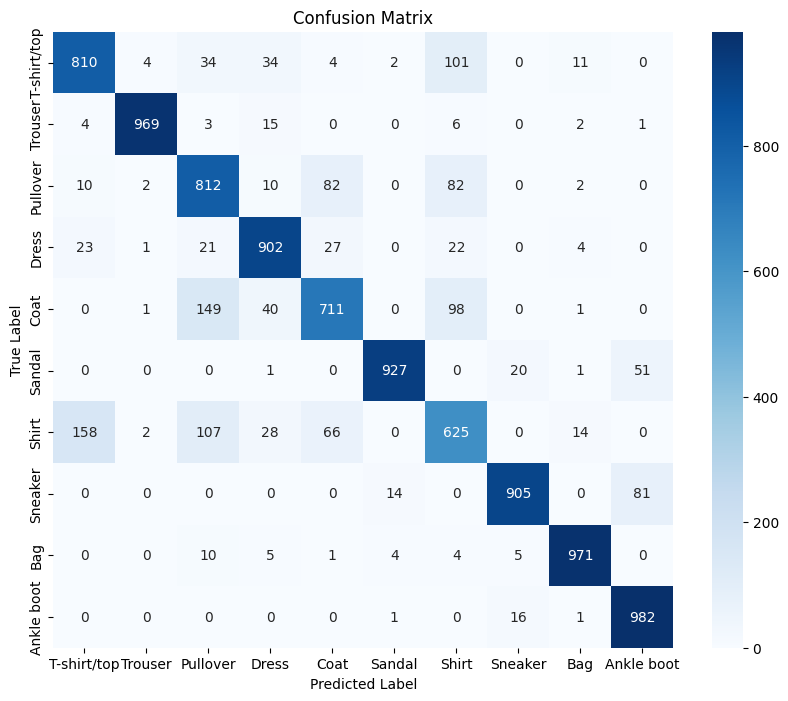

In [146]:
# Predict the classes of the test images
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

# Generate the confusion matrix
cm = confusion_matrix(fashion_test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [147]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/main')
from iterative_approximation.Algorithm1 import *

import statistics

import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code')
from iterative_approximation.Algorithm2 import *
from iterative_approximation.Algorithm2Step import *
from iterative_approximation.Algorithm2StepPruning import *
from iterative_approximation.Algorithm1 import *
import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [148]:
def extract_weight_array(layer):
    kernel, recurrent_kernel = layer.get_weights()

    I = np.hstack([kernel[:, :layer.units].T,recurrent_kernel[:, :layer.units].T])
    F = np.hstack([kernel[:, layer.units:2*layer.units].T,recurrent_kernel[:, layer.units:2*layer.units].T])
    O = np.hstack([kernel[:, 2*layer.units:3*layer.units].T,recurrent_kernel[:, 2*layer.units:3*layer.units].T])
    C = np.hstack([kernel[:, 3*layer.units:].T,recurrent_kernel[:, 3*layer.units:].T])
    return [I,F,O,C]


In [149]:
def set_layer_weight(layer,original_layer,weight_array):

    input_len = original_layer[0].shape[0]
    
    approximated_kernel = np.hstack([weight_array[0][:,:input_len].T,weight_array[1][:,:input_len].T,weight_array[2][:,:input_len].T,weight_array[3][:,:input_len].T])

    approximated_recurrent_kernel = np.hstack([weight_array[0][:,input_len:].T,weight_array[1][:,input_len:].T,weight_array[2][:,input_len:].T,weight_array[3][:,input_len:].T])

    approximated_weight = [approximated_kernel,approximated_recurrent_kernel]
    
    layer.set_weights(approximated_weight)


In [150]:
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy_baseline = accuracy_score(fashion_test_labels, predicted_classes)
accuracy_baseline

313/313 [==============================] - 2s 7ms/step


0.8614

In [151]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)


MSE_list = [0.007,0.006,0.005,0.004,0.003]

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# method1: single matrix approximation
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)

Single_W1_memory_footprints = []
Single_W1_mses = []

W_MSE = 0.01

Single_accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step1()
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step1()
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    Single_W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Single_W1_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Single_accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 [==============================] - 2s 6ms/step


In [152]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

MSE_list = [0.007,0.006,0.005,0.004,0.003]

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# method1: single matrix approximation
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)

Group4_W1_memory_footprints = []
Group4_W1_mses = []

W_MSE = 0.01

Group4_accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2()
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step2()
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    Group4_W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Group4_W1_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Group4_accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Group 4 with Frobenius norm
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
Group4_W2_memory_footprints = []
Group4_W2_mses = []

W_MSE = 0.01

Group4_accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2_norm('fro')
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step2_norm('fro')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    Group4_W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Group4_W2_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Group4_accuracy_result2.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Group 4 with spectral norm
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
Group4_W3_memory_footprints = []
Group4_W3_mses = []

W_MSE = 0.01

Group4_accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2_norm('spec')
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step2_norm('spec')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    Group4_W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Group4_W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Group4_accuracy_result3.append(accuracy)


model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 [==============================] - 2s 7ms/step


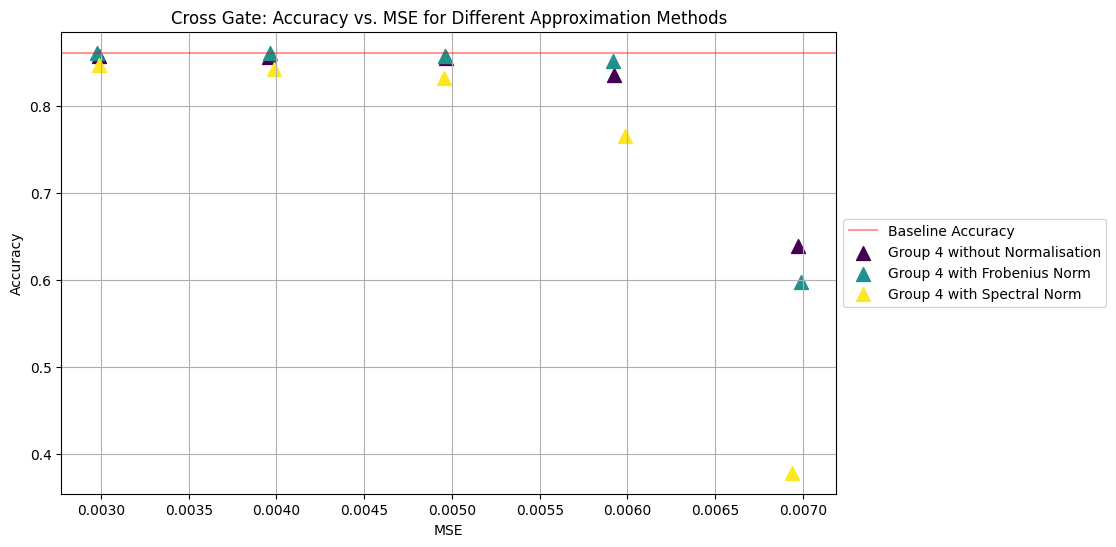

In [153]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [Group4_W1_mses, Group4_W2_mses, Group4_W3_mses]
accuracy_results = [Group4_accuracy_result1, Group4_accuracy_result2, Group4_accuracy_result3]
label_list = ['Group 4 without Normalisation','Group 4 with Frobenius Norm','Group 4 with Spectral Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Cross Gate: Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

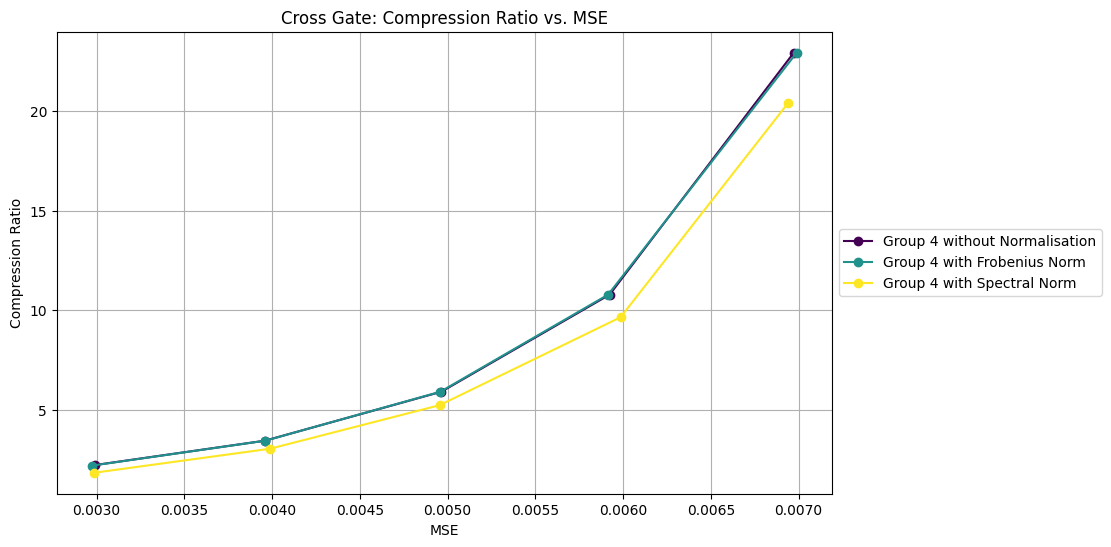

In [154]:
# Baseline memory footprint
baseline_mem_footprint = 3145728

mse_lists = [Group4_W1_mses, Group4_W2_mses, Group4_W3_mses]
label_list = ['Group 4 without Normalisation','Group 4 with Frobenius Norm','Group 4 with Spectral Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in Group4_W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in Group4_W2_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in Group4_W3_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

In [155]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

MSE_list = [0.007,0.006,0.005,0.004,0.003]

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# Stack 4 without normalisation
W1 = WeightArrayStepPruning(W,'weight',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,64,192,1,1)

Stack4_W1_memory_footprints = []
Stack4_W1_mses = []

W_MSE = 0.01

Stack4_accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3()
        W1_MSE = W1.average_mse_weight()
        W2_approximated = W2.iterative_approximation_step3()
        W2_MSE = W2.average_mse_weight()
        W_MSE = (W1_MSE + W2_MSE)/2

    Stack4_W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Stack4_W1_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Stack4_accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Stack 4 with Frobenius norm
W1 = WeightArrayStepPruning(W,'weight',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,64,192,1,1)
Stack4_W2_memory_footprints = []
Stack4_W2_mses = []

W_MSE = 0.01

Stack4_accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3_norm('fro')
        W1_MSE = W1.average_mse_weight()
        W2_approximated = W2.iterative_approximation_step3_norm('fro')
        W2_MSE = W2.average_mse_weight()
        W_MSE = (W1_MSE + W2_MSE)/2

    Stack4_W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Stack4_W2_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Stack4_accuracy_result2.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Stack 4 with spectral norm
W1 = WeightArrayStepPruning(W,'weight',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,64,192,1,1)
Stack4_W3_memory_footprints = []
Stack4_W3_mses = []

W_MSE = 0.01

Stack4_accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3_norm('spec')
        W1_MSE = W1.average_mse_weight()
        W2_approximated = W2.iterative_approximation_step3_norm('spec')
        W2_MSE = W2.average_mse_weight()
        W_MSE = (W1_MSE + W2_MSE)/2

    Stack4_W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Stack4_W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Stack4_accuracy_result3.append(accuracy)


model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 [==============================] - 2s 6ms/step


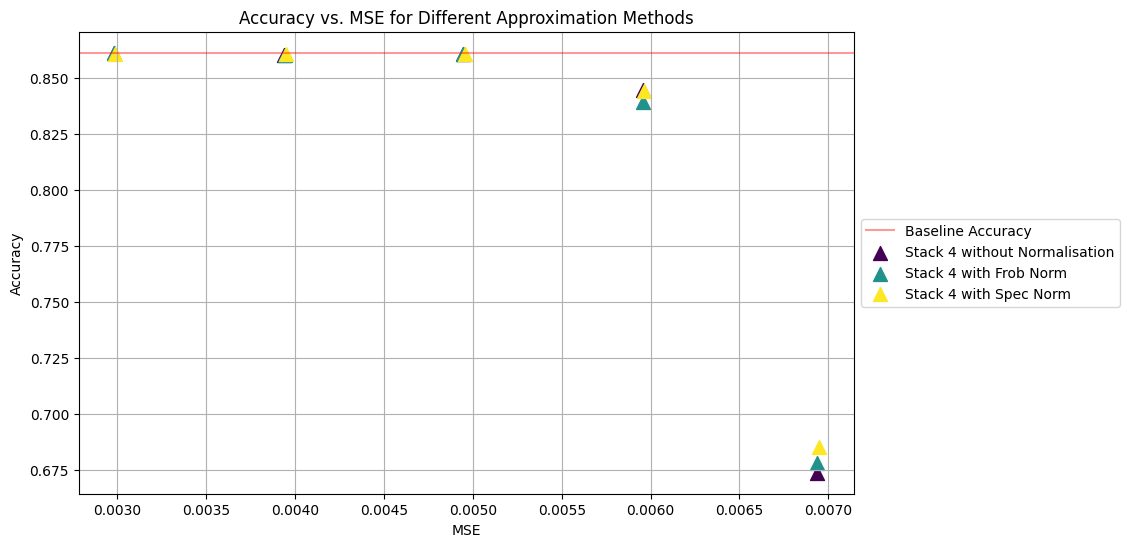

In [156]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [Stack4_W1_mses, Stack4_W2_mses, Stack4_W3_mses]
accuracy_results = [Stack4_accuracy_result1, Stack4_accuracy_result2, Stack4_accuracy_result3]
label_list = ['Stack 4 without Normalisation','Stack 4 with Frob Norm','Stack 4 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

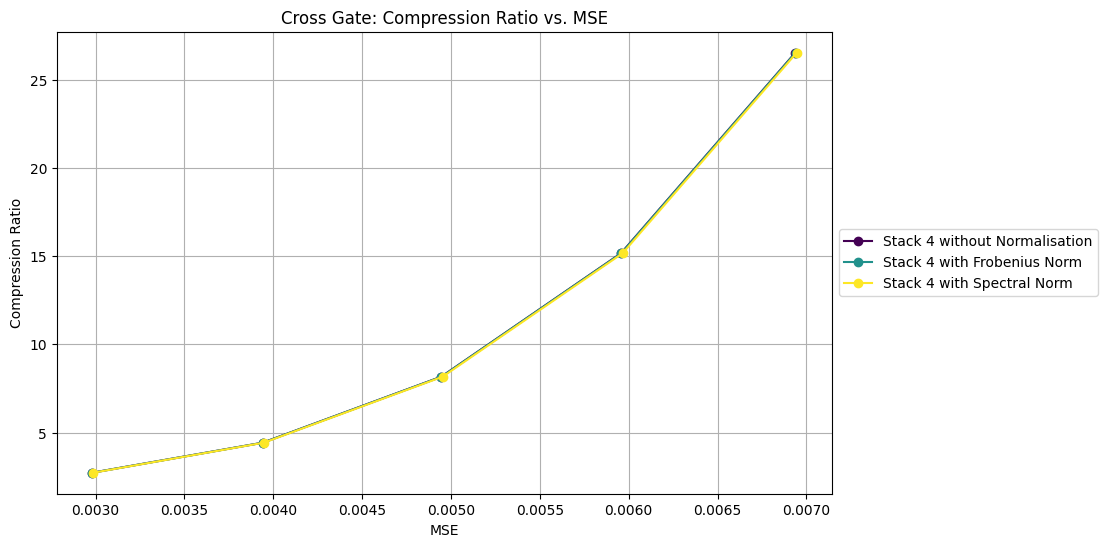

In [157]:
# Baseline memory footprint
baseline_mem_footprint = 3145728

mse_lists = [Stack4_W1_mses, Stack4_W2_mses, Stack4_W3_mses]
label_list = ['Stack 4 without Normalisation','Stack 4 with Frobenius Norm','Stack 4 with Spectral Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in Stack4_W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in Stack4_W2_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in Stack4_W3_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

In [159]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

MSE_list = [0.007,0.006,0.005,0.004,0.003]
# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# hybrid 1
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W1_memory_footprints = []
W1_mses = []

W_MSE = 0.01

accuracy_result1 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(1)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(1)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W1_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 3
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W2_memory_footprints = []
W2_mses = []

W_MSE = 0.01

accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(3)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(3)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W2_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result2.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


# hybrid 5
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W3_memory_footprints = []
W3_mses = []

W_MSE = 0.01

accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(5)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(5)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result3.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


# hybrid 6
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W4_memory_footprints = []
W4_mses = []

W_MSE = 0.01

accuracy_result4 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(6)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(6)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W4_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W4_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result4.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


313/313 [==============================] - 2s 6ms/step


In [160]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

# hybrid 1 normalised Frob
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W5_memory_footprints = []
W5_mses = []

W_MSE = 0.01

accuracy_result5 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(1,'fro')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(1,'fro')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W5_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W5_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result5.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 3 normalised Frob
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W6_memory_footprints = []
W6_mses = []

W_MSE = 0.01

accuracy_result6 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(3,'fro')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(3,'fro')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W6_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W6_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result6.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 6 normalised Frob
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W7_memory_footprints = []
W7_mses = []

W_MSE = 0.01

accuracy_result7 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(6,'fro')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(6,'fro')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W7_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W7_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result7.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 [==============================] - 2s 6ms/step


In [161]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

# hybrid 1 normalised spec
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W8_memory_footprints = []
W8_mses = []

W_MSE = 0.01

accuracy_result8 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(1,'spec')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(1,'spec')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W8_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W8_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result8.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 3 normalised spec
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W9_memory_footprints = []
W9_mses = []

W_MSE = 0.01

accuracy_result9 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(3,'spec')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(3,'spec')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W9_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W9_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result9.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 6 normalised spec
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W10_memory_footprints = []
W10_mses = []

W_MSE = 0.01

accuracy_result10 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(6,'spec')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(6,'spec')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W10_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W10_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result10.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 [==============================] - 2s 6ms/step


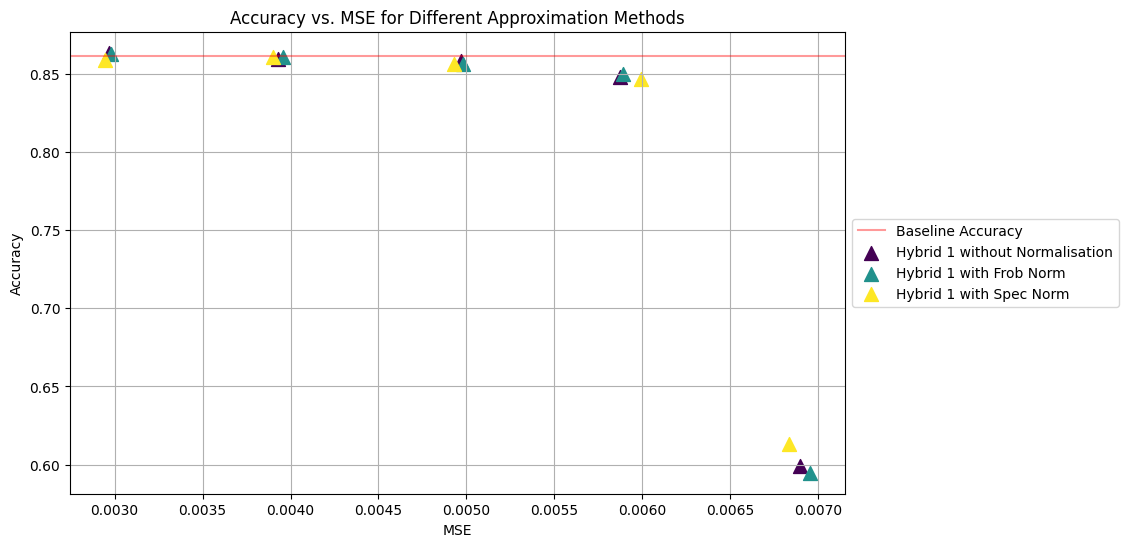

In [162]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
# mse_lists = [W1_mses, W2_mses, W3_mses,W4_mses, W5_mses, W6_mses,W7_mses, W8_mses, W9_mses,W10_mses]
# accuracy_results = [accuracy_result1, accuracy_result2, accuracy_result3,accuracy_result4, accuracy_result5, accuracy_result6,accuracy_result7, accuracy_result8, accuracy_result9,accuracy_result10]
# label_list = ['Hybrid 1 without Normalisation','Hybrid 3 without Normalisation','Hybrid 5 without Normalisation','Hybrid 6 without Normalisation','Hybrid 1 with Frob Norm','Hybrid 3 with Frob Norm','Hybrid 6 with Frob Norm','Hybrid 1 with Spec Norm','Hybrid 3 with Spec Norm','Hybrid 6 with Spec Norm']

mse_lists = [W1_mses, W5_mses, W8_mses]
accuracy_results = [accuracy_result1, accuracy_result5, accuracy_result8]
label_list = ['Hybrid 1 without Normalisation','Hybrid 1 with Frob Norm','Hybrid 1 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

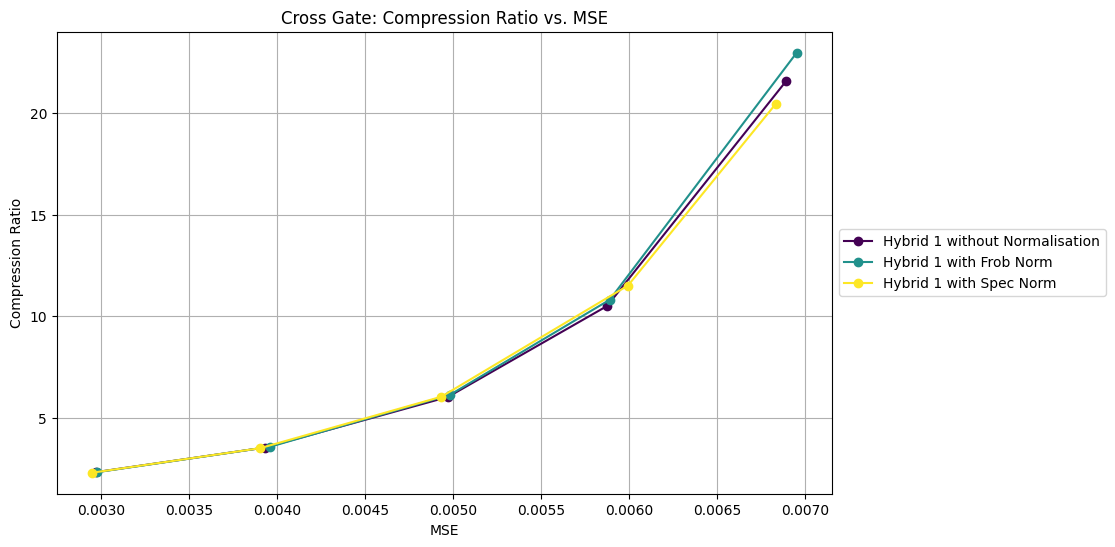

In [163]:
# Baseline memory footprint
baseline_mem_footprint = 3145728

mse_lists = [W1_mses, W5_mses, W8_mses]
label_list = ['Hybrid 1 without Normalisation','Hybrid 1 with Frob Norm','Hybrid 1 with Spec Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W5_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W8_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

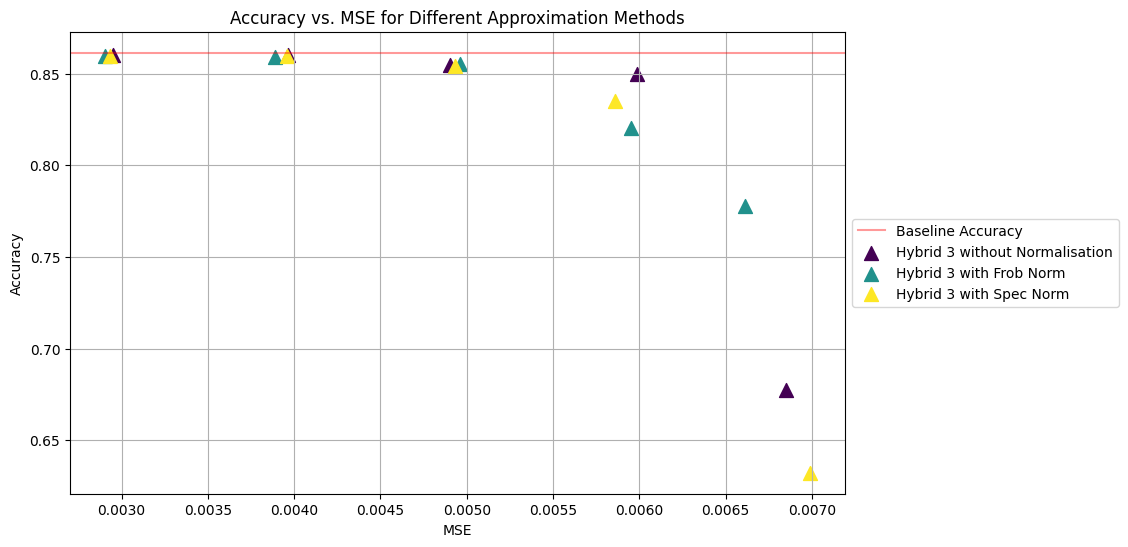

In [164]:
mse_lists = [W2_mses, W6_mses, W9_mses]
accuracy_results = [accuracy_result2, accuracy_result6, accuracy_result9]
label_list = ['Hybrid 3 without Normalisation','Hybrid 3 with Frob Norm', 'Hybrid 3 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

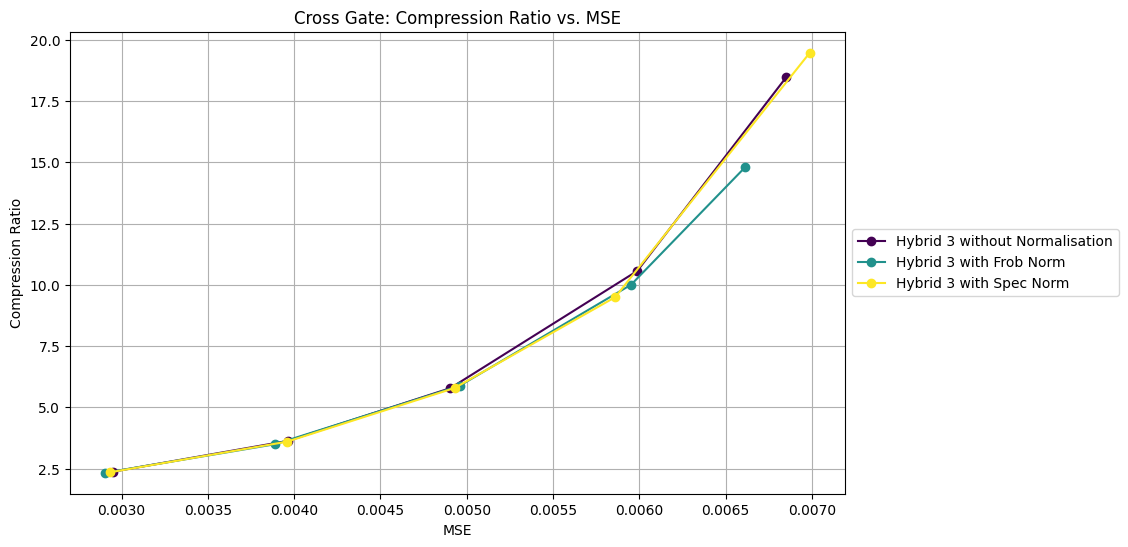

In [165]:
# Baseline memory footprint
baseline_mem_footprint = 3145728

mse_lists = [ W2_mses, W6_mses, W9_mses]
label_list = ['Hybrid 3 without Normalisation','Hybrid 3 with Frob Norm', 'Hybrid 3 with Spec Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W2_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W6_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W9_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

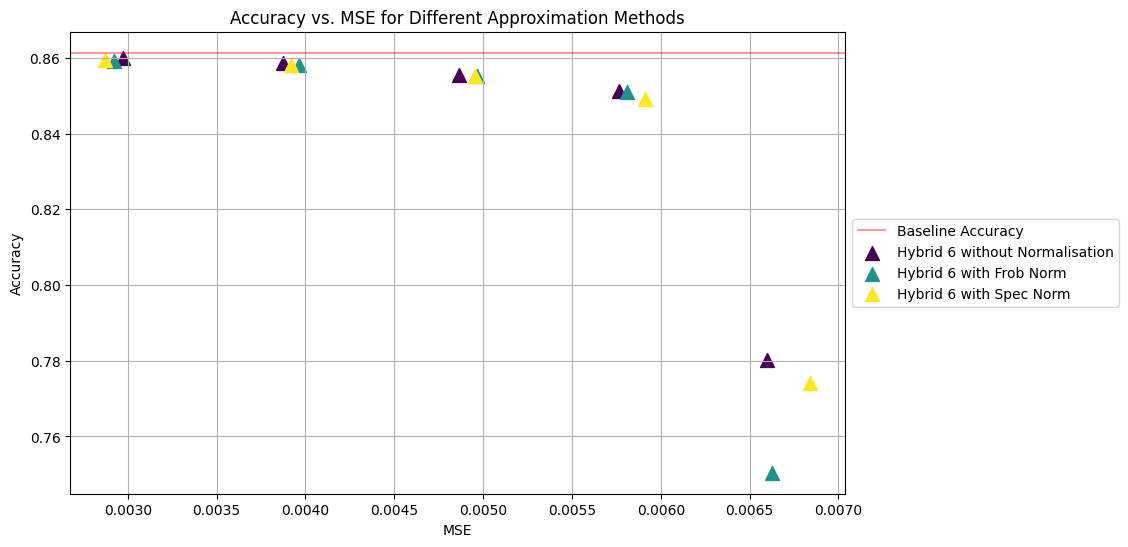

In [166]:
mse_lists = [ W4_mses, W7_mses, W10_mses]
accuracy_results = [accuracy_result4, accuracy_result7, accuracy_result10]
label_list = ['Hybrid 6 without Normalisation','Hybrid 6 with Frob Norm', 'Hybrid 6 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

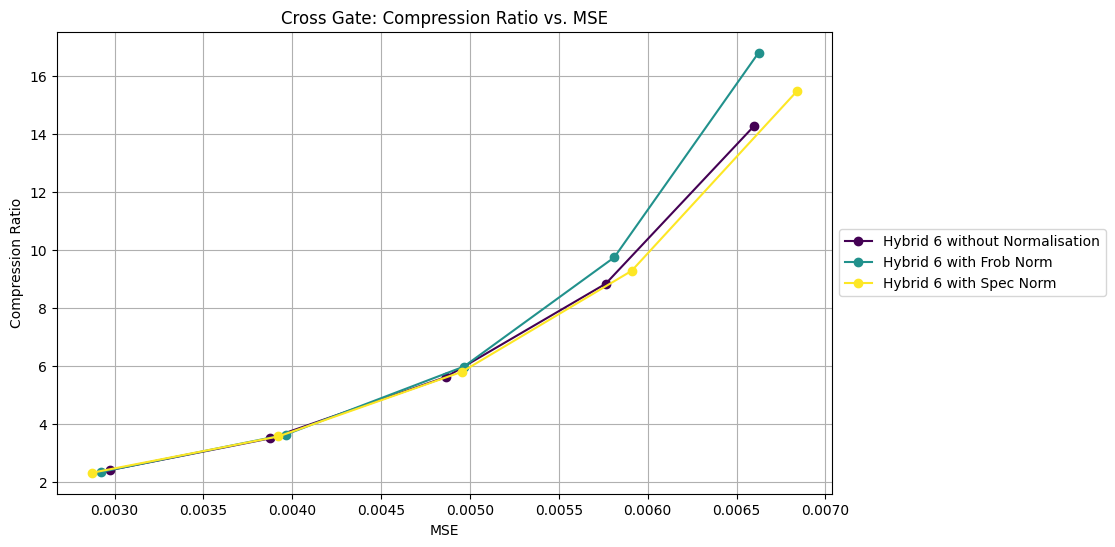

In [167]:
# Baseline memory footprint
baseline_mem_footprint = 3145728

mse_lists = [W4_mses, W7_mses, W10_mses]
label_list = ['Hybrid 6 without Normalisation','Hybrid 6 with Frob Norm', 'Hybrid 6 with Spec Norm']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W4_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W7_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W10_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

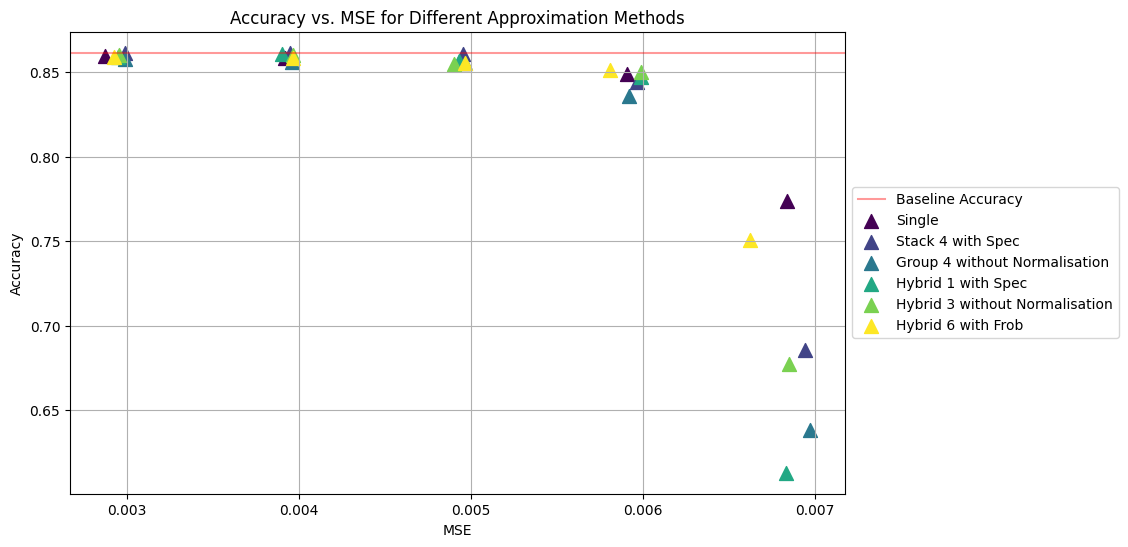

In [168]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [Single_W1_mses,Stack4_W3_mses, Group4_W1_mses, W8_mses, W2_mses,W7_mses]
accuracy_results = [Single_accuracy_result1,Stack4_accuracy_result3, Group4_accuracy_result1, accuracy_result8,accuracy_result2,accuracy_result7]
label_list = ['Single','Stack 4 with Spec','Group 4 without Normalisation','Hybrid 1 with Spec','Hybrid 3 without Normalisation','Hybrid 6 with Frob']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
plt.axhline(y=accuracy_baseline, color='r', alpha = 0.4, label='Baseline Accuracy')

for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

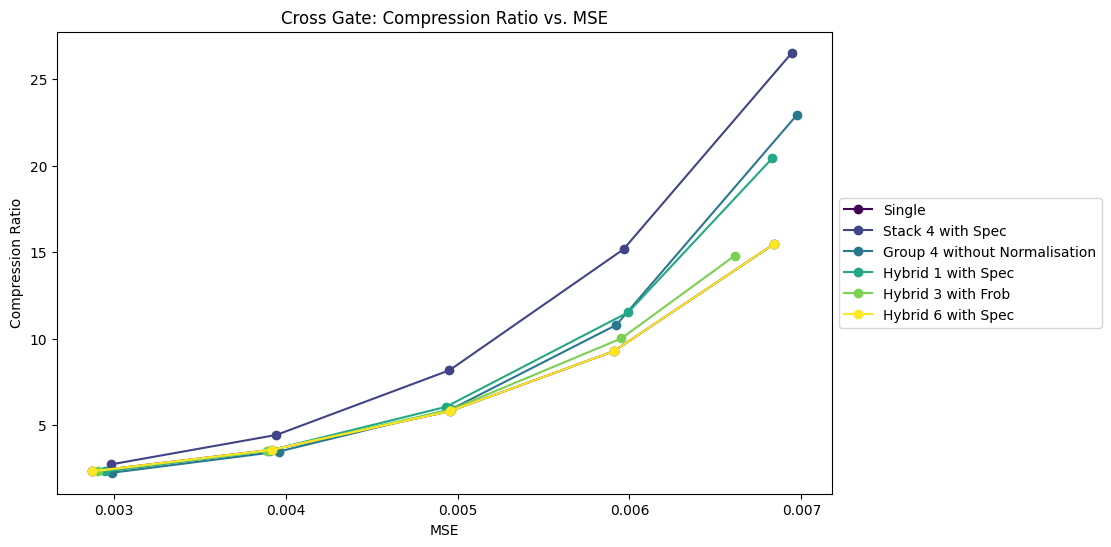

In [169]:
# Baseline memory footprint
baseline_mem_footprint = 3145728

mse_lists = [Single_W1_mses,Stack4_W3_mses, Group4_W1_mses, W8_mses, W6_mses,W10_mses]
label_list = ['Single','Stack 4 with Spec','Group 4 without Normalisation','Hybrid 1 with Spec','Hybrid 3 with Frob','Hybrid 6 with Spec']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in Single_W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in Stack4_W3_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in Group4_W1_memory_footprints]
normalized_W4_mem_footprints = [baseline_mem_footprint/x for x in W8_memory_footprints]
normalized_W5_mem_footprints = [baseline_mem_footprint/x for x in W6_memory_footprints]
normalized_W6_mem_footprints = [baseline_mem_footprint/x for x in W10_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints,normalized_W4_mem_footprints, normalized_W5_mem_footprints,normalized_W6_mem_footprints]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()